In [69]:
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import scanpy as sc
import itertools
import gspread
import celltypist

from httplib2 import Http
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from scipy.stats import zscore
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats
from collections import Counter
from itertools import combinations
from kneed import KneeLocator
import metacells as mc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')  # low dpi (dots per inch) yields small inline figures

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.1 pynndescent==0.5.4


In [70]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [71]:
import decoupler as dc

# Loading data

### Pancreas

In [72]:
pdata = sc.read_10x_mtx("/mc_disk2/data/downloaded_breast/pancreas/", cache=True)

... reading from cache file cache/mc_disk2-data-downloaded_breast-pancreas-matrix.h5ad


In [73]:
md_df = pd.read_csv("/mc_disk2/data/downloaded_breast/pancreas/GSE243466_Metadata_df.csv", index_col=0)

In [74]:
np.isin(md_df.index, pdata.obs.index).all()

True

In [75]:
pdata.obs = pd.merge(pdata.obs, md_df, left_index=True, right_index=True, how='outer')

In [76]:
pdata[md_df.index,]

View of AnnData object with n_obs × n_vars = 11347 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'type', 'tissue', 'replicate', 'seurat_clusters', 'ManuscriptClusters', 'ManuscriptClustersByMaturation', 'UMAP_1', 'UMAP_2'
    var: 'gene_ids', 'feature_types'

In [77]:
pdata.layers['counts'] = pdata.X

In [78]:
pdata.obs.tissue.unique()

array(['BM', 'Tumour', nan, 'Blood', 'Spleen'], dtype=object)

In [79]:
pdata = pdata[pdata.obs.tissue.isin(['Blood', 'Tumour'])]

In [80]:
sc.pp.filter_genes(pdata, min_counts=3)

filtered out 18944 genes that are detected in less than 3 counts


### Breast

In [81]:
ndata = sc.read_h5ad('/mc_disk2/data/h5ads/breast/tumor_blood_neutrophils.h5ad')

In [82]:
ndata.layers['counts'] = ndata.X

In [83]:
ndata.obs['tissue'] = ndata.obs.Tissue

In [84]:
ndata = ndata[ndata.obs.Age.isin(['10w', '11w', '12w'])]

In [85]:
ndata = ndata[ndata.obs.condition.isin(['tumor'])]

In [86]:
ndata = ndata[~ndata.obs.annots.isin(['Cystatin neut', 'Young neut'])]

In [87]:
sc.pp.filter_genes(ndata, min_counts=3)

filtered out 20112 genes that are detected in less than 3 counts


### Colorectal

In [88]:
crc_adata = sc.read_h5ad('/mc_disk2/data/downloaded_breast/colorectal/loaded_crc.h5ad')

In [89]:
crc_adata.X = crc_adata.X.astype(int)

In [90]:
crc_adata.obs['tissue'] = crc_adata.obs.Tissue

In [91]:
sc.pp.filter_genes(crc_adata, min_counts=3)

filtered out 27019 genes that are detected in less than 3 counts


# Integrate

In [92]:
idata = sc.concat([ndata, pdata, crc_adata], join='inner', fill_value=0, label='source', keys=['breast', 'pancreas', 'crc'])

In [93]:
idata.layers['counts'] = idata.X.copy()

In [94]:
idata.shape

(9141, 8743)

In [95]:
shared_genes = idata.var_names

In [96]:
idata.obs.tissue.value_counts()

tissue
Blood               3266
Tumour              2542
Peripheral Blood    2397
Mammary Gland        932
Tumor                  4
Name: count, dtype: int64

In [97]:
idata.obs.tissue = idata.obs.tissue.str.replace('Peripheral Blood', 'Blood').replace('Mammary Gland', 'Tumor').replace('Tumour', 'Tumor')

In [98]:
idata.obs.tissue.value_counts()

tissue
Blood    5663
Tumor    3478
Name: count, dtype: int64

In [99]:
idata.obs.source.value_counts()

source
pancreas    5804
breast      3329
crc            8
Name: count, dtype: int64

# Get DGEs

In [111]:
pb_data = dc.get_pseudobulk(
    idata[:,shared_genes],
    sample_col='source',
    groups_col=['tissue'],
    layer='counts',
    mode='sum',
    min_cells=1,
    min_counts=100
)


In [112]:
pb_data.X = pb_data.X.astype(int)

In [113]:
sc.pp.normalize_total(pb_data, target_sum=1e5)
#sc.pp.log1p(pb_data)

normalizing counts per cell
    finished (0:00:00)


In [114]:
reg = 1

In [115]:
pb_data.obs

,tissue,source,psbulk_n_cells,psbulk_counts
breast_Blood,Blood,breast,2397.0,1252647.0
crc_Blood,Blood,crc,4.0,74002838.0
pancreas_Blood,Blood,pancreas,3262.0,9612475.0
breast_Tumor,Tumor,breast,932.0,307395.0
crc_Tumor,Tumor,crc,4.0,53204821.0
pancreas_Tumor,Tumor,pancreas,2542.0,12817540.0


In [116]:
p_lfc = np.log2((pb_data.X[5] + reg) / (pb_data.X[2] + reg))

In [117]:
c_lfc = np.log2((pb_data.X[4] + reg) / (pb_data.X[1] + reg))

In [118]:
b_lfc = np.log2((pb_data.X[3] + reg) / (pb_data.X[0] + reg))

In [119]:
lfc_df = pd.DataFrame({'gene': pdata.var_names, 'breast_lfc':b_lfc, 'pancreas_lfc':p_lfc, 'crc_lfc':c_lfc}).set_index('gene')

In [141]:
neut_genes = ['Ngp', 'Camp', 'Cd177', 'Mmp8', 'Ifitm6', 'Ltf', 'Ifitm3', 
              'Wfdc21', 'Lcn2', 'Anxa1', 'Retnlg', 
              'Wfdc17', 'Ifitm1', 
              'Srgn', 'Il1b', 'Cd14', 'Dusp1', 'Cxcl2', 'Trem1', 'Btg2', 'Egr1', 'Nfkbia', 'Ccrl2', 'Il1rn', 'Il1r2', 
              'Ptgs2']

In [165]:
max_val = lfc_df.loc[neut_genes].abs().max().max()

In [166]:
max_val

8.03905963897705

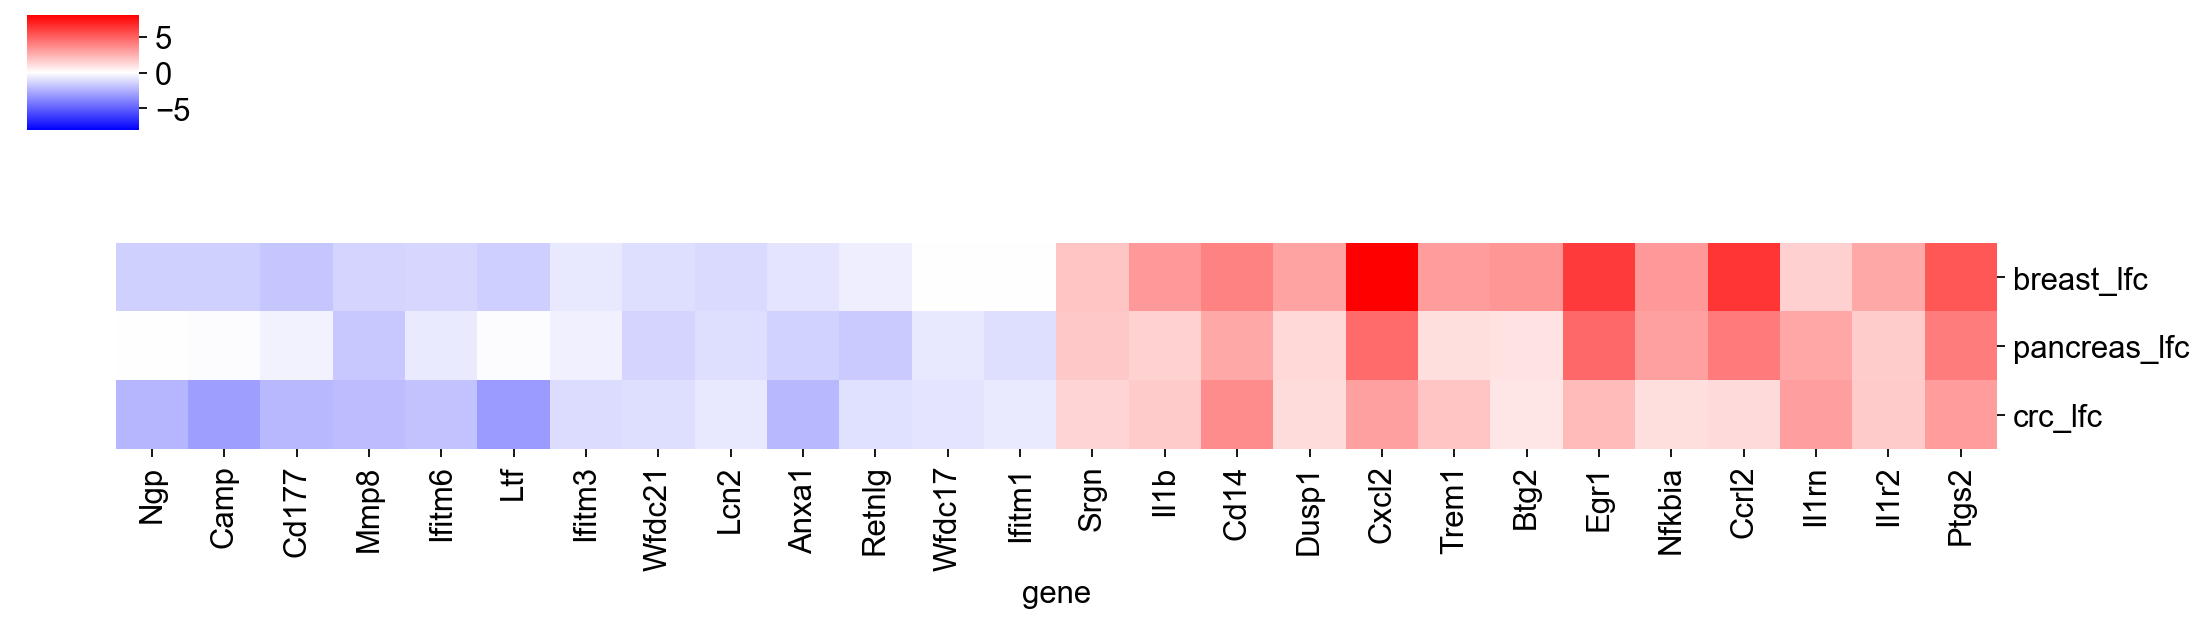

In [167]:
cg = sns.clustermap(lfc_df.loc[neut_genes].T, cmap="bwr", vmin=-max_val, vmax=max_val, center=0, col_cluster=False, row_cluster=False, xticklabels=True, figsize=(14,4), 
               dendrogram_ratio=(0.05, 0.5))
cg.ax_cbar.grid(False)
cg.ax_heatmap.grid(False)
plt.savefig('revision_figs/sig_hm2.pdf')

In [312]:
from scipy.stats import linregress

In [393]:
lin_res = linregress(x=p_lfc, y=b_lfc)

In [394]:
lin_res

LinregressResult(slope=0.35343577691084177, intercept=0.180990493762838, rvalue=0.38464234125658986, pvalue=2.779968628075312e-306, stderr=0.009072050702032137, intercept_stderr=0.006865854695898938)

In [590]:
lfc_df

,breast_lfc,pancreas_lfc,crc_lfc
gene,,,
9930111J21Rik2,-0.425985,-0.714171,-1.011704
AA467197,-0.957092,2.154112,0.832508
AB124611,-0.170454,-1.367890,-1.125240
AI182371,0.612210,-0.061944,-0.000259
AI463170,-0.712506,-0.286305,0.163554
...,...,...,...
Zxdc,0.789978,-0.153595,-1.540939
Zyg11b,0.154528,-0.818258,-1.561482
Zyx,-0.100080,-1.772776,-0.676596


In [704]:
from adjustText import adjust_text

In [819]:
lin_res = linregress(y=lfc_df.breast_lfc, x=lfc_df.pancreas_lfc)

In [820]:
print_list = []
b_plus_p = (lfc_df.breast_lfc + lfc_df.pancreas_lfc).sort_values()
print_list += b_plus_p[:10].index.tolist()
print_list += b_plus_p[-10:].index.tolist()
b_minus_p = (lfc_df.breast_lfc - lfc_df.pancreas_lfc).sort_values()
print_list += b_minus_p[:5].index.tolist()
print_list += b_minus_p[-5:].index.tolist()
print_list = np.unique(print_list)

In [821]:
print_list

array(['AA467197', 'AI467606', 'Apoe', 'Asb7', 'Bcl2a1a', 'Ccl3', 'Ccl4',
       'Ccpg1', 'Ccrl2', 'Cd244a', 'Cdkn1a', 'Cxcl2', 'Cxcl3', 'Egr1',
       'Ffar2', 'Flna', 'Fosb', 'G0s2', 'Hdac4', 'Hspa1b', 'Inhba',
       'Ly6g', 'Orm1', 'Padi4', 'Ptgs2', 'Rab3d', 'Spp1', 'Wfdc18', 'Xpc'],
      dtype='<U8')

In [822]:
lfc_df['shared_bp'] = ~np.logical_xor(lfc_df.breast_lfc > 0, lfc_df.pancreas_lfc > 0)

In [823]:
from scipy.stats import hypergeom

# Given values
N = 8200  # Total number of genes
K = sum(lfc_df.breast_lfc > 0)    # Number of DEGs in condition 1
n = sum(lfc_df.pancreas_lfc > 0)    # Number of DEGs in condition 2
k = sum((lfc_df.breast_lfc > 0) & (lfc_df.pancreas_lfc > 0))    # Observed number of overlapping DEGs

# Calculate the probability of observing exactly k overlaps
probability_exact_k = hypergeom.pmf(k, N, K, n)

# Calculate the p-value (probability of observing k or more overlaps)
p_value = hypergeom.sf(k-1, N, K, n)  # sf is 1 - cdf, so this calculates P(X >= k)

probability_exact_k, p_value

(5.302007223113982e-84, 8.876351202665943e-84)

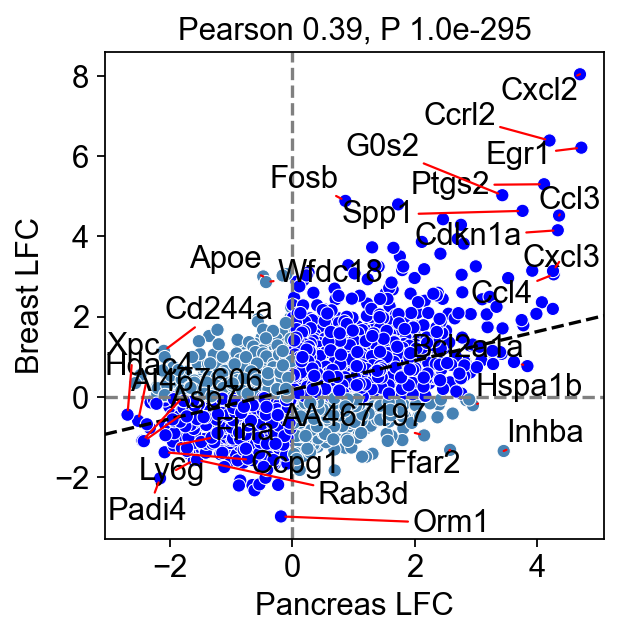

In [824]:
sns.scatterplot(y='breast_lfc', x='pancreas_lfc', data=lfc_df, hue='shared_bp', legend=None, palette=['steelblue', 'blue'])
plt.axhline(0, linestyle='--', color='gray') # horizontal lines
plt.axvline(0, linestyle='--', color='gray') # vertical lines
plt.axline((0,lin_res.intercept),slope=lin_res.slope, color='black', linestyle='--')
plt.xlabel('Pancreas LFC')
plt.ylabel('Breast LFC')
texts = [plt.text(x=lfc_df.loc[pl, 'pancreas_lfc'], y=lfc_df.loc[pl, 'breast_lfc'], s=pl) for pl in print_list]
adjust_text(texts, #expand=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='red') # ensure the labeling is clear by adding arrows
           )
plt.title("Pearson %.2f," % lin_res.rvalue + " P %.1f" % float(str(lin_res.pvalue).split("e")[0]) + "e" + 
          str(lin_res.pvalue).split("e")[1])
plt.grid(False)
plt.savefig("revision_figs/breast_vs_pancreas_lfc.pdf")

In [825]:
print("\n".join(print_list.tolist()))

AA467197
AI467606
Apoe
Asb7
Bcl2a1a
Ccl3
Ccl4
Ccpg1
Ccrl2
Cd244a
Cdkn1a
Cxcl2
Cxcl3
Egr1
Ffar2
Flna
Fosb
G0s2
Hdac4
Hspa1b
Inhba
Ly6g
Orm1
Padi4
Ptgs2
Rab3d
Spp1
Wfdc18
Xpc


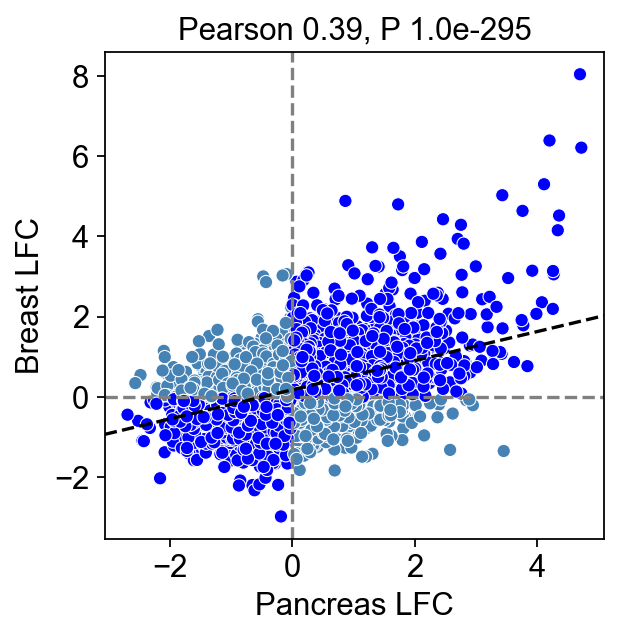

In [826]:
sns.scatterplot(y='breast_lfc', x='pancreas_lfc', data=lfc_df, hue='shared_bp', legend=None, palette=['steelblue', 'blue'])
plt.axhline(0, linestyle='--', color='gray') # horizontal lines
plt.axvline(0, linestyle='--', color='gray') # vertical lines
plt.axline((0,lin_res.intercept),slope=lin_res.slope, color='black', linestyle='--')
plt.xlabel('Pancreas LFC')
plt.ylabel('Breast LFC')
plt.title("Pearson %.2f," % lin_res.rvalue + " P %.1f" % float(str(lin_res.pvalue).split("e")[0]) + "e" + 
          str(lin_res.pvalue).split("e")[1])
plt.grid(False)
plt.savefig("revision_figs/breast_vs_pancreas_lfc_notext.pdf")

In [827]:
lin_res = linregress(y=lfc_df.breast_lfc, x=lfc_df.crc_lfc)

In [828]:
print_list = []
b_plus_p = (lfc_df.breast_lfc + lfc_df.crc_lfc).sort_values()
print_list += b_plus_p[:10].index.tolist()
print_list += b_plus_p[-10:].index.tolist()
b_minus_p = (lfc_df.breast_lfc - lfc_df.crc_lfc).sort_values()
print_list += b_minus_p[:5].index.tolist()
print_list += b_minus_p[-5:].index.tolist()
print_list = np.unique(print_list)

In [829]:
lin_res

LinregressResult(slope=0.3787130039035694, intercept=0.29099453727649915, rvalue=0.41231942649891984, pvalue=0.0, stderr=0.00924186451504923, intercept_stderr=0.007132872798473516)

In [830]:
lfc_df['shared_bc'] = ~np.logical_xor(lfc_df.breast_lfc > 0, lfc_df.crc_lfc > 0)

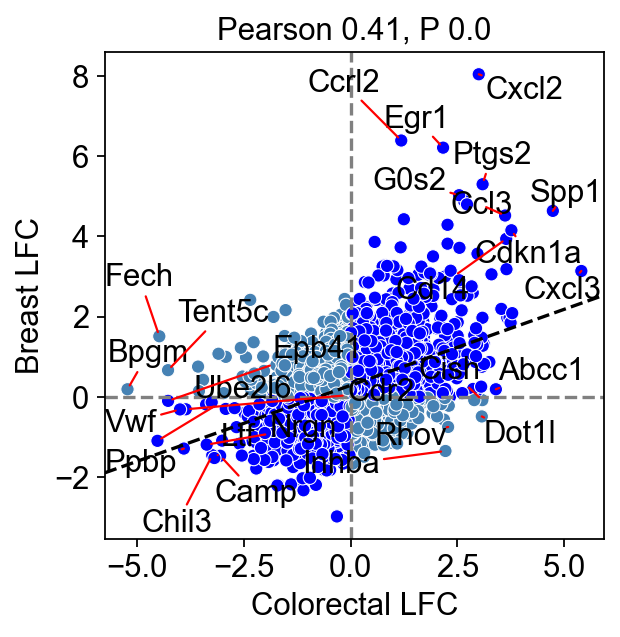

In [831]:
sns.scatterplot(y='breast_lfc', x='crc_lfc', data=lfc_df, hue='shared_bc', legend=None, palette=['steelblue', 'blue'])
plt.axhline(0, linestyle='--', color='gray') # horizontal lines
plt.axvline(0, linestyle='--', color='gray') # vertical lines
plt.axline((0,lin_res.intercept),slope=lin_res.slope, color='black', linestyle='--')
plt.xlabel('Colorectal LFC')
plt.ylabel('Breast LFC')
texts = [plt.text(x=lfc_df.loc[pl, 'crc_lfc'], y=lfc_df.loc[pl, 'breast_lfc'], s=pl) for pl in print_list]
adjust_text(texts, #expand=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='red') # ensure the labeling is clear by adding arrows
           )
plt.title("Pearson %.2f," % lin_res.rvalue + " P 0.0")
plt.grid(False)
plt.savefig("revision_figs/breast_vs_crc_lfc.pdf")

In [832]:
print("\n".join(print_list.tolist()))

Abcc1
Bpgm
Camp
Ccl3
Ccrl2
Cd14
Cdkn1a
Cdr2
Chil3
Cish
Cxcl2
Cxcl3
Dot1l
Egr1
Epb41
Fech
G0s2
Inhba
Ltf
Nrgn
Ppbp
Ptgs2
Rhov
Spp1
Tent5c
Ube2l6
Vwf


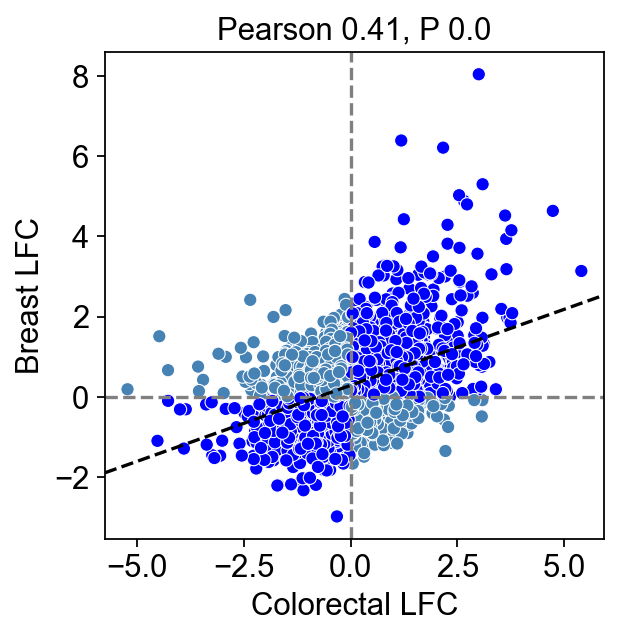

In [833]:
sns.scatterplot(y='breast_lfc', x='crc_lfc', data=lfc_df, hue='shared_bc', legend=None, palette=['steelblue', 'blue'])
plt.axhline(0, linestyle='--', color='gray') # horizontal lines
plt.axvline(0, linestyle='--', color='gray') # vertical lines
plt.axline((0,lin_res.intercept),slope=lin_res.slope, color='black', linestyle='--')
plt.xlabel('Colorectal LFC')
plt.ylabel('Breast LFC')
plt.title("Pearson %.2f," % lin_res.rvalue + " P 0.0")
plt.grid(False)
plt.savefig("revision_figs/breast_vs_crc_lfc_notext.pdf")